# Simulation

The permalgo is a method for generating data that for survival analysis. It has been adapted to be used on time-dependent covariates and implemented as a R library on CRAN. interpret the partial likelihood as a permutational probability. A set of covariate and time-to-event data are generated independently and randomly according to specified marginal distribution. Then each set of covariate will be associated to a time to event (or a censoring time) randomly using a permutational probability identical to the partial likelihood formula. It have been adapted to the use of WCE but not implemented in the CRAN package. 

This package include an implementation of the permalgo that allow the use of WCE variables and is gpu accelerated. It allow the quick simulation of a high number of patients. 




In [1]:
import torch
import os
import sys
import numpy as np


sys.path.append("dev/survivalGPU/python")
from survivalgpu.simulation import simulate_dataset, WCECovariate, ConstantCovariate, TimeDependentCovariate
from survivalgpu.coxph import coxph_R
from survivalgpu.wce import wce_R

[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


In [3]:
# The function simulate_dataset is used to generate a dataset for the survival analysis. The function takes the following arguments:
# The simulation generate a dataset that follow the log likelyhood of a coxph model
# The covariates are defined as objects of the classes WCECovariate, ConstantCovariate, TimeDependentCovariate



Constant_cox = ConstantCovariate(name = "Constant_cox", 
                                 values = [0,1],
                                 coef = np.log(1.5),
                                 weights=[1,2])

list_covariates = [Constant_cox]


dataset = simulate_dataset(max_time =365,
                 n_patients = 1000,
                 list_covariates=list_covariates)


# Verification that the coefficients is correct
print("The simualted dataset is :")
print(dataset)

model = coxph_R(dataset,
               stop = "stop",
               death = "events",
               covars=["Constant_cox"],
               )

print("the coefficient found for the covariate Constant_cox is : ", model["coef"][0,0],"\nThe true coefficient is : ", Constant_cox.coef)


The simualted dataset is :
        patients  fup  start  stop  events  Constant_cox
0              1    1      0     1       1           1.0
1              2    1      0     1       1           1.0
2              3    2      0     1       0           1.0
3              3    2      1     2       1           1.0
4              4    2      0     1       0           1.0
...          ...  ...    ...   ...     ...           ...
153667      1000  363    358   359       0           1.0
153668      1000  363    359   360       0           1.0
153669      1000  363    360   361       0           1.0
153670      1000  363    361   362       0           1.0
153671      1000  363    362   363       1           1.0

[153672 rows x 6 columns]
the coefficient found for the covariate Constant_cox is :  0.3838611 
The true coefficient is :  0.4054651081081644


In [18]:
# We can also add time dependent covariates
time_dependent_covariate = TimeDependentCovariate(name="time_dependent",
                                                values = [0,1,1.5,2,2.5,3],
                                                coef = np.log(1.5))    

# A time_dependant covariate can also be defined as a cumulative covariate
# In this cas it is necessary to define a cutoff time
# The cumulative covariate will be the sum of the values of the covariate until the cutoff time

cumulative_time_dependent_covariate = TimeDependentCovariate(name="cumulative_time_dependent",
                                                values = [0,1,1.5,2,2.5,3],
                                                coef = np.log(1.5),
                                                cumulative=True,
                                                cutoff = 180)


# Several covariates can be defined and added to the list of covariates

list_covariates = [cumulative_time_dependent_covariate]

dataset = simulate_dataset(max_time =365,
                    n_patients = 1000,
                    list_covariates=list_covariates)

# Verification that the coefficients is correct
print("The simualted dataset is :")
print(dataset)



model = coxph_R(dataset,
               stop = "stop",
               death = "events",
               covars=["cumulative_time_dependent"])


# print("the coefficient found for the covariate time_dependant is : ", model["coef"][0,0],"\nThe true coefficient is : ", time_dependent_covariate.coef)
print("the coefficient found for the covariate time_dependant is : ", model["coef"][0,0],"\nThe true coefficient is : ", cumulative_time_dependent_covariate.coef)

                                                                                           


The simualted dataset is :
        patients  fup  start  stop  events  cumulative_time_dependent
0              1    1      0     1       1                        2.5
1              2    2      0     1       0                        2.5
2              2    2      1     2       1                        5.0
3              3    2      0     1       0                        1.0
4              3    2      1     2       0                        2.0
...          ...  ...    ...   ...     ...                        ...
147527      1000  365    360   361       0                       14.0
147528      1000  365    361   362       0                       14.0
147529      1000  365    362   363       0                       14.0
147530      1000  365    363   364       0                       14.0
147531      1000  365    364   365       1                       14.0

[147532 rows x 6 columns]
the coefficient found for the covariate time_dependant is :  0.3439208 
The true coefficient is :  0.40546

In [5]:
# The simulation allow for the simulation of WCE covariates that are used to simulate the effect of a treatment

wce_covariate = WCECovariate(name="wce",
                            values = [1,1.5,2,2.5,3],
                            scenario_name="exponential_scenario",
                            HR_target=1.5)


list_covariates = [wce_covariate]


# Simulate the dataset
dataset = simulate_dataset(max_time = 365,
                           n_patients = 500, 
                           list_covariates=list_covariates)

print(dataset)




       patients  fup  start  stop  events  wce
0             1    2      0     1       0  2.0
1             1    2      1     2       0  2.0
2             2    2      0     1       0  2.0
3             2    2      1     2       1  2.0
4             3    4      0     1       0  1.5
...         ...  ...    ...   ...     ...  ...
79412       500  364    359   360       0  2.5
79413       500  364    360   361       0  2.5
79414       500  364    361   362       0  2.5
79415       500  364    362   363       0  2.5
79416       500  364    363   364       1  2.5

[79417 rows x 6 columns]


In [20]:
# Multiple WCE covariates can be defined and added to the list of covariates
# Classical cox covariates can also be added to the model 


wce_covariate_1 = WCECovariate(name="wce_1",
                            values = [1,1.5,2,2.5,3],
                            scenario_name="exponential_scenario",
                            HR_target=1.5)

wce_covariate_2 = WCECovariate(name="wce_2",
                            values = [1,1.5,2,2.5,3],
                            scenario_name="exponential_scenario",
                            HR_target=1.5)


ConstantCovariate 

time_dependent_covariate = TimeDependentCovariate(name="time_dependent",
                                                values = [0,1,1.5,2,2.5,3],
                                                coef = np.log(1.5))    

cumulative_time_dependent_covariate = TimeDependentCovariate(name="cumulative_time_dependent",
                                                values = [0,1,1.5,2,2.5,3],
                                                coef = np.log(2),
                                                cumulative=True,
                                                cutoff = 180)


Constant_covariate = ConstantCovariate(name = "Constant_covariate", 
                                    values = [0,1],
                                    coef = np.log(1.5),
                                    weights=[1,2])

list_covariates = [wce_covariate_1, wce_covariate_2, time_dependent_covariate, cumulative_time_dependent_covariate, Constant_covariate]

dataset = simulate_dataset(max_time = 365,
                            n_patients = 500, 
                            list_covariates=list_covariates)

print(dataset)

       patients  fup  start  stop  events  wce_1  wce_2  time_dependent  \
0             1    2      0     1       0    2.5    1.0             1.5   
1             1    2      1     2       1    2.5    1.0             1.5   
2             2    3      0     1       0    1.0    1.5             1.5   
3             2    3      1     2       0    1.0    1.5             1.5   
4             2    3      2     3       1    1.0    1.5             1.5   
...         ...  ...    ...   ...     ...    ...    ...             ...   
79942       500  364    359   360       0    1.0    2.5             0.0   
79943       500  364    360   361       0    1.0    2.5             0.0   
79944       500  364    361   362       0    1.0    2.5             0.0   
79945       500  364    362   363       0    1.0    2.5             0.0   
79946       500  364    363   364       1    1.0    2.5             0.0   

       cumulative_time_dependent  Constant_covariate  
0                            0.0            

There are several scenarios available for data simulation with the permalgo, they can be accessed with the function get_scenario. These scenario are normalized so that the sum of each of their 

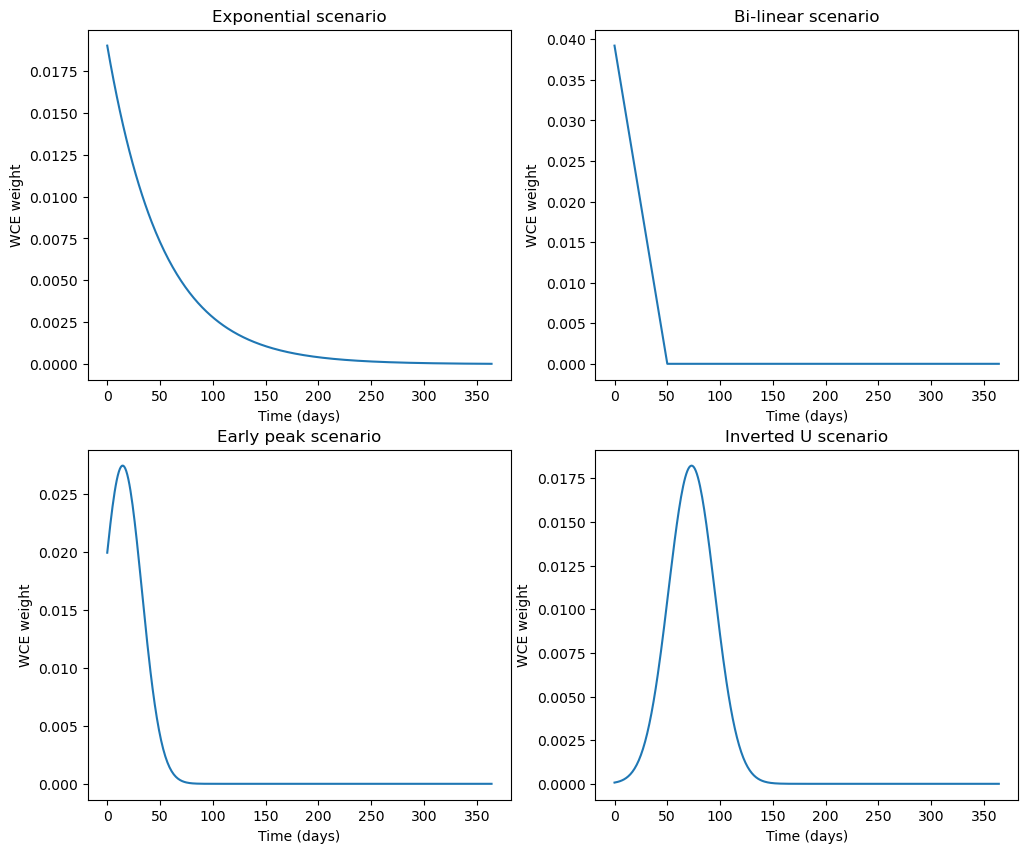

In [4]:
import torch
import os
import sys
import pykeops
import numpy as np
import pykeops

sys.path.append("dev/survivalGPU/python")

os.getcwd()

from survivalgpu.simulation import get_scenario
import matplotlib.pyplot as plt
import numpy as np


inverted_u_scenario = get_scenario(scenario_name = "inverted_u_scenario", max_time = 365)


fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Generate and plot the exponential scenario
exponential_scenario = get_scenario(scenario_name = "exponential_scenario", max_time = 365)
plt.subplot(2,2,1)
plt.plot(np.arange(365), exponential_scenario)
plt.title("Exponential scenario")
plt.xlabel("Time (days)")
plt.ylabel("WCE weight")

# Generate and plot the bi-linear scenario
bi_linear_scenario = get_scenario(scenario_name = "bi_linear_scenario", max_time = 365)
plt.subplot(2,2,2)
plt.plot(np.arange(365), bi_linear_scenario)
plt.title("Bi-linear scenario")
plt.xlabel("Time (days)")
plt.ylabel("WCE weight")

# Generate and plot the early peak scenario
early_peak_scenario = get_scenario(scenario_name = "early_peak_scenario", max_time = 365)
plt.subplot(2,2,3)
plt.plot(np.arange(365), early_peak_scenario)
plt.title("Early peak scenario")
plt.xlabel("Time (days)")
plt.ylabel("WCE weight")

# Generate and plot the inverted U scenario
inverted_u_scenario = get_scenario(scenario_name = "inverted_u_scenario", max_time = 365)
plt.subplot(2,2,4)
plt.plot(np.arange(365), inverted_u_scenario)
plt.title("Inverted U scenario")
plt.xlabel("Time (days)")
plt.ylabel("WCE weight")

plt.show()